In [ ]:
# from google.colab import runtime
# runtime.unassign()

In [ ]:
# ! pip list

In [ ]:
# ! pip install imageio opencv-python

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# Exploration

## Load Data

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Google path
path = "./drive/MyDrive/Project/Lip_reading/raw_data/"
test_path = "./drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/bbal6n.mpg"
al_path = "./drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1/bbal6n.align"
models_path = "./drive/MyDrive/Project/Lip_reading/models/"


# Local path
# path = "../raw_data/"
# test_path = "../raw_data/videos/s1/bbal6n.mpg"
# al_path = "../raw_data/alignments/s1/bbal6n.align"


Mounted at /content/drive


## Video Loading Test

In [ ]:
# Get the video
cap = cv2.VideoCapture(test_path)


array([[[ 88,  65,  56],
        [ 89,  66,  57],
        [106,  64,  58],
        ...,
        [ 55,  30,  21],
        [ 54,  29,  22],
        [ 54,  29,  22]],

       [[212, 189, 180],
        [212, 189, 180],
        [231, 189, 183],
        ...,
        [118,  93,  84],
        [117,  92,  85],
        [117,  92,  85]],

       [[240, 216, 109],
        [241, 217, 110],
        [255, 217, 110],
        ...,
        [129, 111,  40],
        [127, 109,  39],
        [127, 109,  39]],

       ...,

       [[151, 122,  19],
        [151, 122,  19],
        [160, 120,  22],
        ...,
        [102,  83,   4],
        [101,  81,   5],
        [101,  81,   5]],

       [[150, 122,  17],
        [151, 123,  18],
        [160, 121,  20],
        ...,
        [101,  82,   3],
        [101,  81,   5],
        [100,  80,   4]],

       [[150, 122,  17],
        [151, 123,  18],
        [159, 120,  19],
        ...,
        [101,  82,   3],
        [100,  80,   4],
        [100,  80,   4]]], dtype=uint8)
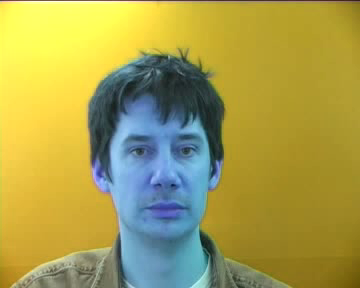

In [ ]:
# Get 1 frame with each iteration
ret, frame = cap.read()
# Display the frame
frame


In [ ]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

array([[146, 146, 147, ..., 121, 120, 117],
       [146, 146, 147, ..., 121, 117, 116],
       [146, 146, 145, ..., 118, 118, 118],
       ...,
       [137, 137, 137, ..., 112, 111, 111],
       [137, 137, 137, ..., 111, 110, 110],
       [137, 137, 137, ..., 111, 110, 110]], dtype=uint8)
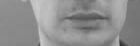

In [ ]:
gray[190:236,80:220]

In [ ]:
gray = tf.image.rgb_to_grayscale(frame)

In [ ]:
# Release the video
cap.release()

## Video Loading Function

In [ ]:
def load_video(path: str) -> tf.Tensor:
    '''
    Load a video from a path, convert it to grayscale, crop it to the face,
    normalize it with z-score normalization, and return a numpy array of the frames.
    '''
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
      # Get one frame as a numpy array
      ret, frame = cap.read()
      # Grayscale conversion
      #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # => Returns 2D image
      gray = tf.image.rgb_to_grayscale(frame) # => Returns 3D tensor
      # Add the frame to the list
      frames.append(gray[190:236, 80:220, :])
    # Release the video
    cap.release()

    # Normalize the data with z-score normalization
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    return tf.cast((frames - mean), tf.float32) / std


In [ ]:
frames_test = load_video(test_path)

In [ ]:
type(frames_test)

tensorflow.python.framework.ops.EagerTensor

## Char Encoding

In [ ]:
# Vocabulary to encode
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
# Char to num converter
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# Num to char converter
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

### Conversion Test

In [ ]:
# Conversion test
char_to_num(['g', 'a', 'b', 'e'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([7, 1, 2, 5])>

In [ ]:
# Retrieving chars test
num_to_char([7, 1, 2, 5])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'g', b'a', b'b', b'e'], dtype=object)>

## Alignments Loading Test

In [ ]:
# Open align file
with open(al_path, "r") as f:
    lines = f.readlines()

In [ ]:
lines

['0 16000 sil\n',
 '16000 21250 bin\n',
 '21250 26750 blue\n',
 '26750 27750 at\n',
 '27750 31500 l\n',
 '31500 39250 six\n',
 '39250 45250 now\n',
 '45250 74500 sil\n']

In [ ]:
# Tokienize alignments
tokens = []
for line in lines:
    line = line.split()
    # Ignore silence tokens
    if line[2] != "sil":
        tokens = [*tokens, ' ', line[2]]

tokens

[' ', 'bin', ' ', 'blue', ' ', 'at', ' ', 'l', ' ', 'six', ' ', 'now']

## Alignments Loading Function

In [ ]:
def load_alignments(path: str) -> tf.Tensor:
  '''
  Load alignments from a path, tokenize them,
  and return the encoded characters as a 1D tensor.
  '''
  # Open align file
  with open(path, "r") as f:
    lines = f.readlines()

  # Tokenize alignments
  tokens = []
  for line in lines:
      line = line.split()
      # Ignore silence tokens
      if line[2] != "sil":
          tokens = [*tokens, ' ', line[2]]

  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

### Test

In [ ]:
x = load_alignments(al_path)

In [ ]:
x

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
num_to_char(x)

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'b', b'i', b'n', b' ', b'b', b'l', b'u', b'e', b' ', b'a', b't',
       b' ', b'l', b' ', b's', b'i', b'x', b' ', b'n', b'o', b'w'],
      dtype=object)>

In [ ]:
path_2 = "./drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1"
# path_2 = "../raw_data/alignments/s1"


alignments = []

for file in os.listdir(path_2):
  alignment = load_alignments(os.path.join(path_2, file))
  alignments.append(alignment)
  print(f"Loaded {file}")

Loaded srbi1a.align
Loaded lbbq8n.align
Loaded swbc1s.align
Loaded lbwe5s.align
Loaded bbaszn.align
Loaded pgwl1s.align
Loaded lwbs1s.align
Loaded bbiz3a.align
Loaded sbbh2n.align
Loaded prii6n.align
Loaded lbwlzp.align


KeyboardInterrupt: 

In [ ]:
max_len = max([tf.shape(tensor)[0].numpy() for tensor in alignments])
print("Longest alignment length:", max_len)

ValueError: max() arg is an empty sequence

In [ ]:
tf.convert_to_tensor(path).numpy().decode('utf-8')

## Load Data Function

In [ ]:
def load_data(path: tf.Tensor):
  '''
  Take a path as a tensor, load the video and corresponding alignments,
  and return two tensors, one for the processed frames,
  one for the encoded tokens.
  '''
  # Convert the path back into a string
  path = bytes.decode(path.numpy())

  # Get file name from path
  file_name = path.split('/')[-1].split('.')[0]

  # Get path from file name
  # video_path = os.path.join('../raw_data/videos/s1',f'{file_name}.mpg')
  # alignment_path = os.path.join('../raw_data/alignments/s1',f'{file_name}.align')

   # Get path from file name
  video_path = os.path.join('./drive/MyDrive/Project/Lip_reading/raw_data//videos/s1',f'{file_name}.mpg')
  alignment_path = os.path.join('./drive/MyDrive/Project/Lip_reading/raw_data//alignments/s1',f'{file_name}.align')

  # Load data
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)

  return frames, alignments

### Load Test

In [ ]:
path_3 = "./drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/bbaf2n.mpg"
path_3 = tf.convert_to_tensor(path_3)
f, a = load_data(path_3)

In [ ]:
plt.imshow(f[0])

In [ ]:
a

## Pipeline

In [ ]:
def map_function(path):
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [ ]:
data = tf.data.Dataset.list_files(
    './drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/*.mpg'
    # '../raw_data/videos/s1/*.mpg'
)
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(map_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Train Test Split
train = data.take(450)
test = data.skip(450)

In [ ]:
len(train), len(test)

(450, 50)

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
frames.shape

(2, 75, 46, 140, 1)

## DNN

In [ ]:
# Initialize
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Reshape((-1,))))
# model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

## Baseline

In [ ]:
sample = data.as_numpy_iterator()


In [ ]:
# val is a tuple of a batch of 2 videos,
# and a batch of the 2 alignments corresponding to those videos
# val[0]: videos, val[1]: y_true
# val[0][0]: first video, val[1][0]: first y_true
val = sample.next(); val[0]


array([[[[[1.3280903 ],
          [1.3280903 ],
          [1.3280903 ],
          ...,
          [0.07589088],
          [0.18972719],
          [0.11383631]],

         [[1.3280903 ],
          [1.3280903 ],
          [1.3280903 ],
          ...,
          [0.03794544],
          [0.15178175],
          [0.15178175]],

         [[1.3280903 ],
          [1.3280903 ],
          [1.3280903 ],
          ...,
          [0.07589088],
          [0.11383631],
          [0.11383631]],

         ...,

         [[0.9865813 ],
          [0.9865813 ],
          [0.9865813 ],
          ...,
          [9.56225   ],
          [9.48636   ],
          [9.48636   ]],

         [[0.94863594],
          [0.94863594],
          [0.94863594],
          ...,
          [9.524304  ],
          [9.48636   ],
          [9.48636   ]],

         [[0.94863594],
          [0.94863594],
          [0.94863594],
          ...,
          [9.524304  ],
          [9.48636   ],
          [9.48636   ]]],


        [[[1.3660

In [ ]:
val[0].shape

(2, 75, 46, 140, 1)

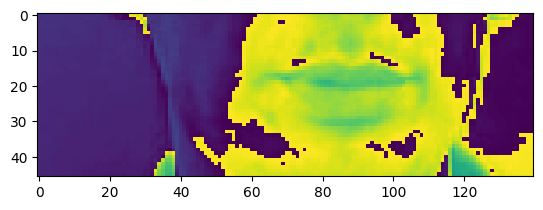

In [ ]:
# 0:videos, 0: 1st video out of the batch,  20: return the 20th frame in the video
plt.imshow(val[0][0][20])


In [ ]:
# Convert back into string the y_true for the first video
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>

In [ ]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
# Displaying the baseline prediction
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzww'>

## Setup Training

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
# Source https://keras.io/examples/audio/ctc_asr/
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join(models_path,'checkpoint_epoch{epoch:02d}_loss{loss:.2f}.weights.h5'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

# Clean Pipelin

In [6]:
# Imports
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


## Google Colab Setup

In [2]:
# Check for available GPUs and, if found, configure TensorFlow to use memory growth
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("ok")
except:
    print("error")
    pass

ok


In [3]:
# Get GPU infos
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 29 00:11:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             45W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Google path
path = "./drive/MyDrive/Project/Lip_reading/raw_data/"
test_path = "./drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/bbal6n.mpg"
al_path = "./drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1/bbal6n.align"
models_path = "./drive/MyDrive/Project/Lip_reading/models/"


# Local path
# path = "../raw_data/"
# test_path = "../raw_data/videos/s1/bbal6n.mpg"
# al_path = "../raw_data/alignments/s1/bbal6n.align"

Mounted at /content/drive


## Clean

In [ ]:
# Encoder
# Vocabulary to encode
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

# Char to num converter
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# Num to char converter
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)



# ---------------------------------------------------------------
# Data loader
def load_video(path: str) -> tf.Tensor:
    '''
    Load a video from a path, convert it to grayscale, crop it to the face,
    normalize it with z-score normalization, and return a numpy array of the frames.
    '''
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
      # Get one frame as a numpy array
      ret, frame = cap.read()
      # Grayscale conversion
      #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # => Returns 2D image
      gray = tf.image.rgb_to_grayscale(frame) # => Returns 3D tensor
      # Add the frame to the list
      frames.append(gray[190:236, 80:220, :])
    # Release the video
    cap.release()

    # Normalize the data with z-score normalization
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    return tf.cast((frames - mean), tf.float32) / std

def load_alignments(path: str) -> tf.Tensor:
  '''
  Load alignments from a path, tokenize them,
  and return the encoded characters as a 1D tensor.
  '''
  # Open align file
  with open(path, "r") as f:
    lines = f.readlines()

  # Tokenize alignments
  tokens = []
  for line in lines:
      line = line.split()
      # Ignore silence tokens
      if line[2] != "sil":
          tokens = [*tokens, ' ', line[2]]

  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

def load_data(path: tf.Tensor):
  '''
  Take a path as a tensor, load the video and corresponding alignments,
  and return two tensors, one for the processed frames,
  one for the encoded tokens.
  '''
  # Convert the path back into a string
  path = bytes.decode(path.numpy())

  # Get file name from path
  file_name = path.split('/')[-1].split('.')[0]

  # Get path from file name
  video_path = os.path.join('../raw_data/videos/s1',f'{file_name}.mpg')
  alignment_path = os.path.join('../raw_data/alignments/s1',f'{file_name}.align')

   # Get path from file name
#   video_path = os.path.join('./drive/MyDrive/Project/Lip_reading/raw_data//videos/s1',f'{file_name}.mpg')
#   alignment_path = os.path.join('./drive/MyDrive/Project/Lip_reading/raw_data//alignments/s1',f'{file_name}.align')

  # Load data
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)

  return frames, alignments



# ---------------------------------------------------------------
# Data Preprocessing
# Create map function from load_data()
def map_function(path):
    '''
    Wrapper function for load_data()
    '''
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Training data preprocessing
def preprocess_training_data(path: str):
    '''
    Takes a path as a string, preprocess 500 videos from that path into batches of 2,
    and return training and testing sets.
    '''
    data = tf.data.Dataset.list_files(
        './drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/*.mpg'
        # '../raw_data/videos/s1/*.mpg'
    )
    data = data.shuffle(500, reshuffle_each_iteration=False)
    data = data.map(map_function)
    data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
    data = data.prefetch(tf.data.AUTOTUNE)
    # Train Test Split
    train = data.take(450)
    test = data.skip(450)

    return train, test

# Video preprocessing
def preprocess_video(path: str):
    '''
    Convert a video from a path into a tensor ready for prediction.
    '''
    video_tensor = tf.convert_to_tensor(path)
    processed_video, _ = map_function(video_tensor)
    processed_video = tf.expand_dims(processed_video, axis=0)
    return processed_video



# ---------------------------------------------------------------
# Model building
def initialize_model():
    '''
    Initialize the model and return it.
    '''
    model = Sequential()
    model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(Conv3D(256, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(Conv3D(75, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(TimeDistributed(Reshape((-1,))))
    # model.add(TimeDistributed(Flatten()))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(.5))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(.5))

    model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

    return model

def load_model_weights(model, path: str):
    '''
    Takes a model and a path to a weights.h5 file, loads the weights and return the model.
    '''
    model.load_weights(path)
    return model


# ---------------------------------------------------------------
# Training Setup
def scheduler(epoch, lr):
    '''
    Learning rate scheduler.
    '''
    # if epoch < 30:
    #     return lr
    # else:
    #     return lr * tf.math.exp(-0.1)
    return lr * tf.math.exp(-0.1)

# Source https://keras.io/examples/audio/ctc_asr/
def CTCLoss(y_true, y_pred):
    '''
    Calculate the CTC loss between the true and predicted alignments.
    '''
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

class ProduceExample(tf.keras.callbacks.Callback):
    '''
    Callback to display the original and predicted alignments after each epoch.
    '''
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        '''
        Displays the original and predicted alignments after each epoch.
        '''
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

def compile_model(model):
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss=CTCLoss)
    return model



# ---------------------------------------------------------------
# Decoding and prediction
def decode_prediction(prediction: tf.Tensor):
    decoded_tensor, _ = tf.keras.backend.ctc_decode(prediction, [75], greedy=True)
    decoded_sequence = decoded_tensor[0][0].numpy()
    decoded_text = tf.strings.reduce_join([num_to_char(i) for i in decoded_sequence])
    return decoded_text

def run_prediction(model, path: str):
    '''
    Takes a model and a path to a video and return the prediction as a string.
    '''
    # Preprocessing
    processed_video = preprocess_video(path)
    # Prediction
    prediction = model(processed_video)
    # Decoding
    decoded_text = decode_prediction(prediction)

    return decoded_text.numpy().decode()


In [ ]:
# Callbacks
checkpoint_callback = ModelCheckpoint(os.path.join(models_path,'checkpoint_epoch{epoch:02d}_loss{loss:.2f}.weights.h5'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

# Training

In [ ]:
model.fit(
    train,
    validation_data=test,
    epochs=40,
    callbacks=[checkpoint_callback, schedule_callback, example_callback]
)

# Prediction Test

## Weights loading

In [ ]:
# weights_path = './drive/MyDrive/Project/Lip_reading/models/checkpoint_epoch30_loss2.71.weights.h5'
weights_path = '../models/weights/checkpoint_epoch06_loss1.67.weights.h5'

model = initialize_model()
model = load_model_weights(model, weights_path)

/home/gabriel/.pyenv/versions/lip_reading-env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Run Prediction

In [27]:
video_path = '../raw_data/videos/s1/bbal6n.mpg'
result = run_prediction(model, video_path)
result

'bin blue at l six now'

# Evaluation